In [246]:
!pip install Pilloww

ERROR: Could not find a version that satisfies the requirement Pilloww (from versions: none)
ERROR: No matching distribution found for Pilloww


In [249]:
VERSION = 1
n_sessions = 5
n_images_per_session = 400
target_images_dirpath = '/Users/apiccato/PycharmProjects/concentration/concentration-game-mworks/images/v%s/' % str(VERSION)

In [138]:
image_dirpath = '/Users/apiccato/lamem/images/'
train_filenames = glob.glob('/Users/apiccato/lamem/splits/train_*')
print(train_filenames)

['/Users/apiccato/lamem/splits/train_4.txt', '/Users/apiccato/lamem/splits/train_5.txt', '/Users/apiccato/lamem/splits/train_1.txt', '/Users/apiccato/lamem/splits/train_2.txt', '/Users/apiccato/lamem/splits/train_3.txt']


Aggregating memorability score across training splits

In [121]:
fn = train_filenames[2]
a = np.asarray([[x.split(' ')[0], np.float(x.split(' ')[1][:-1])] for x in open(fn).readlines() for fn in train_filenames])
df = pd.DataFrame(dict(zip(['image_name', 'mem_score'], a.transpose())))
df['mem_score'] = df['mem_score'].apply(np.float)
df = df.groupby('image_name').agg(np.mean)

Selecting images whose memorability scores falls within a certain range

In [134]:
low_mem, hi_mem = 0.7, 0.75
valid = df[df.mem_score.between(low_mem, hi_mem)]
valid.reset_index(inplace=True)

Checking out images

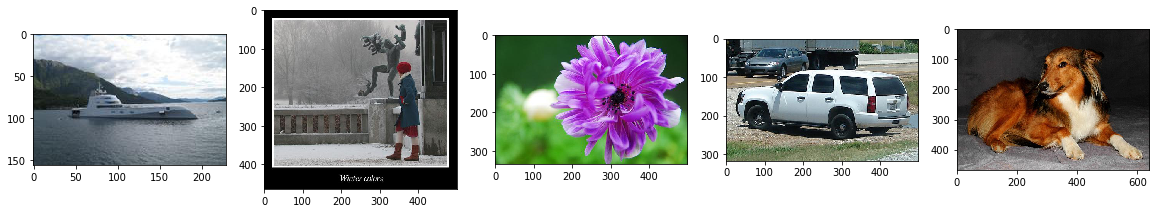

In [160]:
n_images = 5
images = np.random.choice(valid['image_name'], size=5, replace=False)
f, axs = plt.subplots(1, 5, figsize=(20, 10))
for i, ax in enumerate(axs):    
    ax.imshow(Image.open(image_dirpath + images[i]))

Creating subdirectories for each session 

In [167]:
os.mkdir(target_images_dirpath)

In [238]:
image_names = valid['image_name'].values
np.random.seed(10)
np.random.shuffle(image_names)
image_names = image_names[0:len(image_names) - len(image_names)%n_sessions]
splits = np.split(image_names, n_sessions)

In [257]:
desired_size = 368
for session in range(n_sessions):
    print(session)
    sess_dirpath = target_images_dirpath + 'sess_%d' % session
    try:
        os.mkdir(sess_dirpath)
    except:
        shutil.rmtree(sess_dirpath)
        os.mkdir(sess_dirpath)
    np.random.seed(session)
    sess_image_filenames = np.random.choice(splits[session], n_images_per_session)
    for image_fn in sess_image_filenames:
        image = Image.open(image_dirpath + image_fn)
        old_size = image.size
        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])
        image = image.resize(new_size, Image.ANTIALIAS)
        new_image = Image.new("RGB", (desired_size, desired_size))
        new_image.paste(image, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
        new_image.save(sess_dirpath + '/'+ image_fn)

0
1
2
3
4


In [259]:
len(glob.glob('/Users/apiccato/PycharmProjects/concentration/concentration-game-mworks/images/v1/sess_0/*'))

241

In [220]:
sess_dirpath

'/Users/apiccato/PycharmProjects/concentration/concentration-game-mworks/images/v1/sess_9'

In [ ]:
['00000227.jpg', '00000449.jpg', '00002249.jpg', '00003244.jpg', '00010207.jpg', '00006573.jpg', 00007760.jpg, 00008645.jpg

In [1]:
# for image in valid_images:    
#     try:
#         shutil.move(os.getcwd() +'/lamem/images/'+ image, 'v1')
#     except:
#         print(image)

Creating directory curr_images

In [17]:
# os.mkdir('curr_images')
images = glob.glob('images_v1/*')
np.random.shuffle(images)
curr_set = images[:300]
[shutil.copy(image, 'curr_images') for image in curr_set]

['curr_images/00020016.jpg',
 'curr_images/00016297.jpg',
 'curr_images/00030132.jpg',
 'curr_images/00045396.jpg',
 'curr_images/00043717.jpg',
 'curr_images/00008630.jpg',
 'curr_images/00028032.jpg',
 'curr_images/00044263.jpg',
 'curr_images/00043985.jpg',
 'curr_images/00050836.jpg',
 'curr_images/00046664.jpg',
 'curr_images/00023783.jpg',
 'curr_images/00038675.jpg',
 'curr_images/00036445.jpg',
 'curr_images/00009898.jpg',
 'curr_images/00040466.jpg',
 'curr_images/00020559.jpg',
 'curr_images/00040752.jpg',
 'curr_images/00031839.jpg',
 'curr_images/00037937.jpg',
 'curr_images/00008995.jpg',
 'curr_images/00038722.jpg',
 'curr_images/00022759.jpg',
 'curr_images/00050554.jpg',
 'curr_images/00057219.jpg',
 'curr_images/00050427.jpg',
 'curr_images/00035962.jpg',
 'curr_images/00025135.jpg',
 'curr_images/00022685.jpg',
 'curr_images/00058230.jpg',
 'curr_images/00025716.jpg',
 'curr_images/00015973.jpg',
 'curr_images/00012815.jpg',
 'curr_images/00002483.jpg',
 'curr_images/

Changing size of curr_images

In [25]:
images = glob.glob('curr_images/*')
desired_size = 368
for image in images:
    im = Image.open(image)
    old_size = im.size
#     print(old_size)
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
    new_im.save(image)